# Advanced Text Analytics Lab 1

This notebook is the first of two lab notebooks that you will submit as part of your assessment for the Advanced Data Analytics unit. 

This notebook is contains three sections:
1. **Word embeddings:** This will introduce you to loading and training word embeddings using the Gensim library.
2. **Introducing neural text classifiers:** Here we show you how to construct a neural network text classifier for sentiment analysis using Pytorch. 
3. **Improving neural text classifiers:** This section gives you a chance to improve the classifier from the previous section by applying what we have learned in the lectures.

## Learning Outcomes

These sections will contain tutorial-like instructions, as you have seen in previous text analytics labs. On completing these sections, the intended learning outcomes are that you will be able to...
1. Load pretrained word embeddings models.
1. Learn word embeddings from an unlabelled dataset.
1. Recognise the steps required to train and test a neural text classifier with Pytorch
1. Adapt the architecture of a neural text classifier.

## Getting Started -- Python Packages

Please see the README.md file for instructions on setting up your Python environment. The readme will instruct you to install the required packages, in addition to those used for Introduction to Data Analytics:

 * pytorch=1.9.0
 * scipy=1.8.0
 * transformers=2.1.1

## Your Tasks

Inside each of these sections there are several **'To-do's**, which you must complete for your summative assessment. Your marks will be based on your answers to these to-dos. Please make sure to:
1. Include the output of your code in the saved notebook. Plots and printed output should be visible without re-running the code. 
1. Include all code needed to generate your answers.
1. Provide sufficient comments to understand how your method works.
1. Write text in a cell in markdown format where a written answer is required. You can convert a cell to markdown format by pressing Escape-M. 

There are also some unmarked 'to-do's that are part of the tutorial to help you learn how to implement and use the methods studied here. These do not contribute to your final marks.

## Good Academic Practice

Please follow [the guidance on academic integrity provided by the university](http://www.bristol.ac.uk/students/support/academic-advice/academic-integrity/).
You are required to write your own answers -- do not share your notebooks or copy someone else's writing. Do not copy text or long blocks of code directly into the notebook from online sources -- always rewrite in your own way. Breaking the rules can lead to strong penalties. 

## Marking Criteria

1. The coursework (both notebooks) is worth 30% of the unit in total. 
1. There is a total of 100 marks available for both lab notebooks. 
1. This notebook is worth 50 of those marks.
1. The number of marks for each to-do out of 100 is shown alongside each to-do.
1. For to-dos that require you to write code, a good solution would meet the following criteria (in order of importance):
   1. Solves the task or answers the question asked in the to-do. This means, if the code cells in the notebook are executed in order, we will get the output shown in your notebook.
   1. The code is easy to follow and does not contain unnecessary steps.
   1. The comments show that you understand how your solution works.
   1. A very good answer will also provide code that is computationally efficient but easy to read.
1. You can use any suitable publicly available libraries. Unless the task explicitly asks you to implement something from scratch, there is no penalty for using libraries to implement some steps.

## Support

The main source of support will be during the remaining lab sessions (Fridays 3-6pm) for this unit. 

The TAs and lecturer will help you with questions about the lectures, the code provided for you in this notebook, and general questions about the topics we cover. For the marked 'to-dos', they can only answer clarifying questions about what you have to do. 

Office hours: You can book office hours with Edwin on Mondays 3pm-5pm by sending him an email (edwin.simpson@bristol.ac.uk). If those times are not possible for you, please contact him by email to request an alternative. 

## Deadline

The notebook must be submitted along with the second notebook on Blackboard before **Wednesday 24th May at 13.00**. 

## Submission

You will need to zip up this notebook and the next notebook into a single .zip file, which you will submit to Blackboard through the 'assessment, submission and feedback' link on the left sidebar. 

Please name your files like this:
   * Name this notebook ADA1_<student_number>.ipynb
   * Name the zip file <student_number>.zip
   * Please don't include your name as we want to mark anonymously to ensure fairness. 

# 1. Word Embeddings (max. 12 marks)

In this section we will use both sparse vectors and dense word2vec embeddings to obtain
vector representations of words and documents. 

First, we will load the `tweet eval` sentiment dataset.

In [27]:
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Training dataset with {len(train_dataset)} instances loaded")


dev_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Development/validation dataset with {len(dev_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Put the data into lists ready for the next steps...
train_texts = []
train_labels = []
for i in tqdm(range(len(train_dataset))):
    train_texts.append(train_dataset[i]['text'])
    train_labels.append(train_dataset[i]['label'])
            
# HINT: A count vectorizer object may be useful in later steps
vectorizer = CountVectorizer()
vectorizer.fit(train_texts)

# Get the vocabulary
vocab = vectorizer.vocabulary_
vocab_size = len(vocab)
print(f'The vocabulary has {vocab_size} words')

# invert the vocabulary dictionary so we can look up word types given an index
keys = vocab.values()
values = vocab.keys()
vocab_inverted = dict(zip(keys, values))

print(f'Index of "love" is {vocab["love"]}')

Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 45615 instances loaded


Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Development/validation dataset with 2000 instances loaded


Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 12284 instances loaded


100%|██████████| 45615/45615 [00:01<00:00, 28241.88it/s]


The vocabulary has 43358 words
Index of "love" is 22981


## 1.1. Term-Document Matrix

First we are going to obtain sparse word vectors from a term-document matrix.

**TO-DO 1a:** Use CountVectorizer to obtain a term-document matrix for the training set. Then, write a function that takes a word as an argument and returns its term vector from the term-document matrix you computed. Get the term vector for the word 'love'. **(4 marks)**

In [29]:
# WRITE YOUR ANSWER HERE

# write a function to return the ierm vector of selected word
def get_term_vector(word, vocabulary, term_document_matrix):
    word_index = vocabulary[word]   # get the index of selected word
    term_vector = term_document_matrix[:,word_index]
    return term_vector

term_document_matrix = vectorizer.transform(train_texts).toarray()  # obtain a term-document matrix
love_vector = get_term_vector(word='love', vocabulary=vocab, term_document_matrix=term_document_matrix)
print('The item vector of "love" is:')
print(love_vector)

The item vector of "love" is:
[0 0 0 ... 0 0 0]


In [30]:
# Define a list of words for comparison with 'love' in the next to-do.
comparison_words = ['2wee', '4your', 'follow', 'goodnight', 'liam', 'lol', 'okay', 'sorry',
 'wish', 'yea', 'affair', 'agree', 'all', 'alliums', 'alliumsvancouver', 'always',
 'amazing', 'and', 'appreciate', 'ask', 'babe', 'baby', 'bandit76044', 'barat',
 'beautiful', 'birthday', 'boy', 'bro', 'btw', 'but', 'commando', 'content',
 'dear', 'dm', 'dream', 'dreams', 'enjoy', 'enjoyed', 'everything', 'fam',
 'followers', 'for', 'forever', 'forget', 'friend', 'friends', 'gabrielle',
 'girl', 'god', 'good', 'guys', 'hahaha', 'happy', 'hate', 'hello', 'hey',
 'homework', 'hope', 'in', 'invite', 'is', 'isabel', 'it', 'jonny', 'kiss', 'know',
 'krishna', 'ladies', 'let', 'life', 'like', 'lil', 'little', 'love', 'loved',
 'loves', 'loving', 'lucky', 'luv', 'ma', 'may', 'me', 'mean', 'meet', 'met', 'miss',
 'much', 'my', 'notice', 'nsfanfic', 'nuffsaid', 'nya', 'of', 'on', 'one',
 'ontario', 'perfect', 'prefer', 'queen', 'rails', 'rather', 'recommend',
 'remember', 'see', 'share', 'sing', 'smile', 'so', 'suggest', 'sunat', 'sweet',
 'tag', 'tail', 'tebaklagu', 'thank', 'thanks', 'the', 'this', 'thsoul', 'to',
 'tomorrow', 'too', 'true', 'unreservedly', 'user', 'want', 'weed', 'what', 'wish',
 'wishes', 'with', 'women_of_christ', 'would', 'wow', 'xxxxxx', 'yay', 'yes',
 'you', 'your', 'zorro',
]

**TO-DO 1b:** Write a function that computes the similarity between two different term vectors. For this to-do, do not simply call a library function that implements a similarity function, implement the calculation yourself. Use the function to find the five most similar terms to "love" from the list of `comparison_words` given above. **(6 marks)**

In [31]:
# WRITE YOUR OWN CODE HERE

# define a function to computes the similarity between two different term vectors
def get_cosine_similarity(term_vector_A, term_vector_B):
    assert term_vector_A.shape == term_vector_B.shape       # check if two vectors have the same shape
    return np.sum(term_vector_A * term_vector_B) / (np.sqrt(np.sum(term_vector_A**2)) * np.sqrt(np.sum(term_vector_B**2)))

# iterate word in the "comparison_words" to calculate the cosine similarity with 'love'
word_A = 'love'
term_vector_A = get_term_vector(word_A, vocab, term_document_matrix)
cosine_similarity_values = {}
for word_B in comparison_words:
    cosine_similarity_values[word_B] = get_cosine_similarity(term_vector_A=term_vector_A,
                                                             term_vector_B=get_term_vector(word_B, vocab, term_document_matrix))
# sort 'cosine_similarity_values' by the corresponding cosine similarity
cosine_similarity_values = sorted(cosine_similarity_values.items(), key=lambda x:x[1], reverse=True)

# get the five most similary terms
five_most_similar_terms = list(dict(cosine_similarity_values).keys())[:5]
print(f'The most similar terms to "love" from the list of comparison_word given above are {five_most_similar_terms}.')
cosine_similarity_values[:5]

The most similar terms to "love" from the list of comparison_word given above are ['love', 'you', 'user', 'the', 'and'].


[('love', 1.0),
 ('you', 0.14170441974255654),
 ('user', 0.09879910847998889),
 ('the', 0.08769922256389782),
 ('and', 0.08543046072802546)]

## 1.2 Word Embeddings

Now, we will use Gensim to train a word2vec model. The code below tokenizes the training texts, then runs word2vec (the skipgram model) to learn a set of embeddings. 

In [32]:
from gensim.models import word2vec
from gensim.utils import tokenize

tokenized_texts = [list(tokenize(text)) for text in train_texts]
emb_model = word2vec.Word2Vec(tokenized_texts, sg=1, min_count=1, window=3, vector_size=100)

In [33]:
# get the word vector for 'love'
love_embedding = emb_model.wv['love']

**TODO 1c:** Find the five most similar words to 'love' according to your word2vec model. You can use the Gensim function `similar_by_word` to do this. How does the Word2Vec top 5 differ from the top 5 comparison words found using the term-document matrix? **(2 marks)**

WRITE YOUR ANSWER HERE

The results of word2vec are quite different from those of the term-document matrix. The results of term-document matrix are all dummy words with the low cosine similarity, such as ‘you’, 'the', etc. But the results of word2vec are not. Hence, the results of word2vec are more reasonable.

In [34]:
# WRITE YOUR OWN CODE HERE
print(f'The most similar terms to "love" from the list of comparison_word given above are')
emb_model.wv.similar_by_word(word='love', topn=5)

The most similar terms to "love" from the list of comparison_word given above are


[('thank', 0.8422207236289978),
 ('appreciate', 0.8360515832901001),
 ('Wish', 0.8317209482192993),
 ('Lol', 0.828848659992218),
 ('dreams', 0.8234305381774902)]

Above, we trained our own model using the skipgram method. We can also download a pretrained model that has previously been trained on a large corpus. There is a list of models available [here](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Let's try out GLoVe embeddings. GLoVe is an alternative to the skipgram model. This model was trained on a corpus of tweets:

In [35]:
import gensim.downloader

glove_wv = gensim.downloader.load('glove-twitter-25')

# show the vector for Hamlet:
print(glove_wv['love'])

[-0.62645  -0.082389  0.070538  0.5782   -0.87199  -0.14816   2.2315
  0.98573  -1.3154   -0.34921  -0.8847    0.14585  -4.97     -0.73369
 -0.94359   0.035859 -0.026733 -0.77538  -0.30014   0.48853  -0.16678
 -0.016651 -0.53164   0.64236  -0.10922 ]


TODO 1d: Find the most similar five words to 'happy' according to the GloVe Twitter model. (this task is unmarked)

In [36]:
# WRITE YOUR OWN CODE HERE
glove_wv.similar_by_word(word='happy', topn=5)

[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.9336148500442505),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678)]

Notice again that a different set of words are favoured than with word2vec or term-document vectors, and consider how this might result from pretraining the embeddings on Twitter data.

# 2. Introducing Neural Text Classifiers (max. 16 marks)

This section shows you how to implement a neural network classifier using Pytorch and leads you through the steps required to process text sequences.

There are several big advantages to building a text classifier using a neural network:
   * It can model nonlinear functions, so can handle much more complex relationships between features and class labels.
   * It performs representation learning: the hidden layers learn how to extract features from low-level data.
   * It can process sequences of tokens -- we don't have to think in terms of a single feature vector representing a document as we did for logistic regression.
  
The downsides are:
   * Much more expensive to train and test.
   * It can overfit very badly to small datasets.
   * The features learned by the hidden layers can be hard to interpret, which can make it hard to predict the model's behaviour, e.g., what sort of cases it may fail on.
   
Let's start by building a neural network text classifier that takes a sequence of tokens as input, and predicts a class label. For simplicity, it will use a single fully connected feedforward layer. 


We are going to construct the neural network in this form:

<img src="neural_text_classifier_smaller.png" alt="Neural text classifier diagram" width="600px"/>

The first step -- as always -- is to get our data into the right format. We start from a set of tokenised documents (in this case, tweets), where each document is represented as a sequence of text tokens. The neural network cannot process the tokens as strings, so we need to convert each token to a numerical input value. The input value for each token is used to look up the corresponding embedding in the embedding layer. For PyTorch, it's not necessary to create one-hot vectors for each token, as library just uses the indexes of the words in the vocabulary to look up the corresponding word embedding. 

So, let's now map the tokens to their IDs -- their indexes in the vocabulary:

In [37]:
# tokenize training set and convert to input IDs.
def encode_text(sample):
    tokens = tokenize(sample['text'])  # Tokenize one document
    
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1) # +1 is needed because we reserve 0 as a special character
            
    sample['input_ids'] = input_ids 
    return sample

# The map method of the dataset object takes a function as its argument, 
# and applies that function to each document in the dataset.
train_dataset = train_dataset.map(encode_text)
len(train_dataset)

0ex [00:00, ?ex/s]

45615

In [38]:
np.unique(train_dataset['label'])

array([0, 1, 2])

Our neural network's input layer has a fixed size, so we need to make all of our documents have the same number of tokens. Let's plot a histogram to understand the length distribution of the texts in the training set:

Mean of the document length: 18.160166611860134
Median of the document length: 18.0
Maximum document length: 32


(array([   21.,   522.,  2430.,  4908.,  7772., 11003., 10389.,  6738.,
         1719.,   113.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

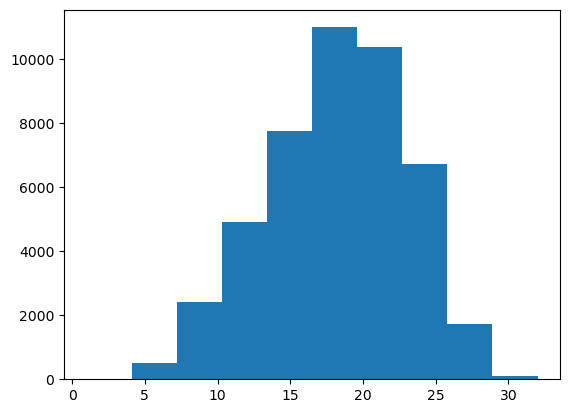

In [39]:
import matplotlib.pyplot as plt

rv_l = [len(doc) for doc in train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

We now neeed to choose a fixed sequence length, then *pad* the documents that are shorter than this maximum by adding a special token to the start of the sequence. The special pad token has an input value of 0. Any documents that exceed the length will be truncated.

**TO-DO 2a:** Complete the padding code below to insert 0s at the start of any sequences that are too short, and to truncate any sequences that are too long. **(3 marks)**

In [40]:
sequence_length = 40  # truncate all docs longer than this. Pad all docs shorter than this.

def pad_text(sample):
    ###WRITE YOUR OWN CODE HERE
    input_ids = sample['input_ids']

    if len(input_ids) > sequence_length:
        # for too long sequence 
        input_ids = input_ids[0:40]     # truncate
    else:
        # for too short sequence
        pad_len = sequence_length - len(input_ids)
        pad_ids = np.zeros(shape=[pad_len], dtype=int).tolist()
        pad_ids.extend(input_ids)       # padding 0s at start of sequence
        input_ids = pad_ids

    # check whether the length of processed sequence equal to the value of sequence_length
    assert len(input_ids) == sequence_length
    sample['input_ids'] = input_ids
    ##########
    
    return sample

# The map method will call pad_text for every document in the dataset
train_dataset = train_dataset.map(pad_text)

0ex [00:00, ?ex/s]

We now have our data in almost the right format! To train a model using PyTorch, we are going to wrap our dataset in a [DataLoader object](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). This allows the training process to select random subsets of the dataset -- mini-batches -- which it will use for learning with mini-batch stochastic gradient descent.

In [41]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(train_labels))   # number of possible labels in the sentiment analysis task

train_loader = convert_to_data_loader(train_dataset, num_classes)

Let's process the development and test set as well.

In [42]:
dev_dataset = dev_dataset.map(encode_text)
dev_dataset = dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(dev_dataset, num_classes)

test_dataset = test_dataset.map(encode_text)
test_dataset = test_dataset.map(pad_text)
test_loader = convert_to_data_loader(test_dataset, num_classes)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

As shown in the diagram above, we will build a NN with three different layers for sentiment classification.

### Embedding layer
In the embedding layer, the network will create its own embeddings for the index with a given embedding dimension.
The module `nn.Embedding()` creates a simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices.
The module's input is a list of indices, and the output is the corresponding word embeddings.

[Documentation for Embedding Class](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

### Fully-connected layer
Fully-connected layers in a neural network are those layers where all the inputs from the previous layer are connected to every unit of the fully-connected layer. Here we will use fully-connected layers for the hidden layer and output layer. In Pytorch this kind of layer is implemented by the 'Linear' class:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

## Activation functions
In Pytorch, the activation function is not included in the Linear class (or other kinds of neural network layer), so we need to explicitly connect each layer to an activation function.
In Pytorch, we construct a neural network by connecting up the output of each component to the input of the next, thereby creating a computation graph.
To complete the hidden layer, we connect the ouput of the linear layer to a ReLU activation function, thereby creating a nonlinear function.

The cell below defines a class for our neural text classifier. The constructor creates each of the layers and the activations. The dimensions of each layer need to be correct so that the output of one layer can be passed as input to the next, but the code is not yet complete.

Below the constructor is the forward method. This is called in the 'forward pass' to map the neural network's inputs to its outputs. In PyTorch, we pass data through each layer of the model, connecting them together, then returning the output of the final layer.

**TO-DO 2b** Complete the constructor and the forward method below for a NN with three layers. The places where you need to add code are marked in the cell below. Refer to the Pytorch documentation for additional help.  **(2 marks)**

In [43]:
from torch import nn

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, sequence_length, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
        
        ### COMPLETE THE CODE HERE: WRITE IN THE MISSING ARGUMENTS SPECIFYING THE DIMENSIONS OF EACH LAYER
        self.hidden_layer = nn.Linear(in_features=embedding_size*sequence_length, out_features=hidden_size) # Fully connected hidden layer
        self.activation = nn.ReLU() # Hidden layer
        ##########
        
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected output layer

        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size

        z = self.hidden_layer(embedded_words)   # (batch_size, seq_length, hidden_size)
        
        ### ADD THE MISSING LINE HERE
        h = self.activation(z)  # (batch_size, seq_length, hidden_size)
        ########

        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

Now the class is complete. 

TO-DO 2c: In the next cell, create a NN with the FFTextClassifier class we wrote. (unmarked)

Hint: `ff_classifier_model = FFTextClassifier(...)`

In [44]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 10  # number of dimensions for embeddings
hidden_size = 8 # number of hidden units

###WRITE YOUR OWN CODE HERE
ff_classifier_model = FFTextClassifier(vocab_size, sequence_length, embedding_size, hidden_size, num_classes)

After desigining our network, we need to create a training function to calculate the loss for each input and perform backpropagation to optimise the network.
During training, the weights of all the layers will be updated.

Below, we build a training function to train the NN over a fixed number of epochs (an epoch is one iteration over the whole training dataset).
The function also prints the performance of both training and development/validation set after each epoch.

Here we use cross-entropy loss, which is the standard loss function for classification that we also used for logistic regression. The module `nn.CrossEntropyLoss()` operates directly on the output of our output layer, so we don't have to implement the softmax layer within the forward() method.

Cross Entropy Loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

The optimizer object implements a particular algorithm for updating the weights. Here, we will use the Adam optimizer, which is a variant of stochastic gradient descent method that tends to find a better solution in a smaller number of iterations than standard SGD.

Optimization: https://pytorch.org/docs/stable/optim.html

The cell below defines a training function for our classifier:

In [45]:
from torch import optim

def train_nn(num_epochs, model, train_dataloader, dev_dataloader):

    train_losses_by_epoch = []
    dev_losses_by_epoch = []
    
    learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
        
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        train_losses_by_epoch.append(np.mean(train_losses))
        
        # Compute accuracy on dev set after this training epoch
        
        model.eval()  # Switch model to evaluation mode - turn off any random steps such as dropout
        total_correct = 0
        total_deved = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:            
            # Use the model to perform forward inference on the input data.
            dev_output = model(dev_input_ids)
            # Compute the loss for the current batch of data
            dev_losses.append(loss_fn(dev_output, dev_labels).item())
            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_deved += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_deved*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
        dev_losses_by_epoch.append(np.mean(dev_losses))

    return model, train_losses_by_epoch, dev_losses_by_epoch

**TO-DO 2d:** Modify the training function above to return the training and development (or 'validation') losses at each epoch. Train the network for 15 epochs and plot the losses. Describe what the plot shows, and how you could use this information to improve the training process. **(8 marks)**

EXPLAIN YOUR ANSWER HERE

There are two line in the line graph. The blue line describe the loss values on the training data. It shows that the training losses decrease with the increase of the training epoch. The orange line describe the loss values on the validation data. It shows that the validation losses decrease before epoch equals to 12 and then begin to fluctuate smoothly. 

After epochs greater than 12, training losses continue to fall, but validation losses are not falling. This phenomenon indicates that the model starts to over-fit after epoch greater than 12. To ensure the robustness of the model and the efficiency of the training, we can select the model of the 11th epoch as the final model and store it.



Epoch: 1/15 Training Loss: 1.0189 Training Accuracy: 44.2990%
Epoch: 1/15 Validation Loss: 1.0106 Validation Accuracy: 45.8000%
Epoch: 2/15 Training Loss: 1.0018 Training Accuracy: 46.5088%
Epoch: 2/15 Validation Loss: 1.0040 Validation Accuracy: 46.7000%
Epoch: 3/15 Training Loss: 0.9835 Training Accuracy: 49.0343%
Epoch: 3/15 Validation Loss: 0.9845 Validation Accuracy: 49.9000%
Epoch: 4/15 Training Loss: 0.9527 Training Accuracy: 52.0004%
Epoch: 4/15 Validation Loss: 0.9561 Validation Accuracy: 50.8000%
Epoch: 5/15 Training Loss: 0.9179 Training Accuracy: 54.8482%
Epoch: 5/15 Validation Loss: 0.9358 Validation Accuracy: 53.8500%
Epoch: 6/15 Training Loss: 0.8835 Training Accuracy: 57.3364%
Epoch: 6/15 Validation Loss: 0.9165 Validation Accuracy: 55.1000%
Epoch: 7/15 Training Loss: 0.8521 Training Accuracy: 59.4673%
Epoch: 7/15 Validation Loss: 0.9038 Validation Accuracy: 55.8000%
Epoch: 8/15 Training Loss: 0.8235 Training Accuracy: 61.2123%
Epoch: 8/15 Validation Loss: 0.8851 Valida

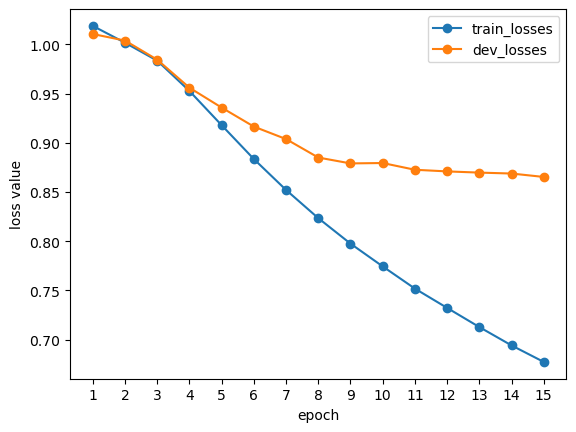

In [46]:
###WRITE YOUR OWN CODE HERE

# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

epochs = 15
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                             model=ff_classifier_model,
                                                             train_dataloader=train_loader,
                                                             dev_dataloader=dev_loader)

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

ax = plt.gca()
x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(range(1, epochs+1), train_losses_by_epoch, '-o', label='train_losses')
plt.plot(range(1, epochs+1), dev_losses_by_epoch, '-o', label='dev_losses')
plt.legend()

The code below obtains predictions from our neural network:

In [47]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()  # switch off some randomisation used during training (dropout) to give consistent predictions

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, labels in test_loader:
        test_output = trained_model(inputs)  # run the forward() function on the inputs
        predicted_labels = test_output.argmax(1)  # select the class labels with highest logits as our predictions

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

gold_labs, pred_labs = predict_nn(trained_model, test_loader)

Now, we can use pretrained word embeddings instead of learning them from scratch during training.
Here, we will use the pretrained GloVe embeddings that we loaded before. The embedding matrix is used to initialise the embedding layer. The code below converts the GloVe embeddings into an embedding matrix suitable for PyTorch:

In [48]:
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])
        
print(embedding_matrix)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3535,  0.0987,  0.1718,  ...,  0.4630,  1.3101,  1.1314],
        [-0.4106,  0.1487,  0.0637,  ...,  0.6097,  1.0935,  0.9614],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


The class below extends the FFTextClassifier class (it's incomplete for now -- you'll fix this in a minute!). This means that it inherits all of its functionality, but we overwrite the constructor (the `__init__` method). This way, we don't need to define the forward function again, as it will be the same as before.

The embedding layer is now different as it loads pretrained embeddings from our matrix. The argument `freeze` determines whether the embeddings remain fixed to their pretrained values (if `freeze=True`) or are updated through backpropagation to fit them to the dataset.

In [49]:
class FFTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer activation
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected layer

**TO-DO 2e:** Complete the arguments in the `FFTextClassifierWithEmbeddings` constructor to set the dimensions of the neural network layers.  Repeat the experiment above using the FFTextClassifierWithEmbeddings with the GLoVe embeddings. Choose a suitable performance metric and compare the performance of the two neural text classifiers. Explain in one or two sentences the possible reason(s) for any performance differences you observe. **(3 marks)**

WRITE YOUR ANSWER HERE:

In the last cell of session 2, I build text reports showing the main classification metrics for the **FFTextClassifier** and  **FFTextClassifierWithEmbeddings**


Due to the uneven distribution of data for each category in the test set, I select weight average F1 score as the performance metric. The specific values, as shown in the table below.

Model     | weight avg F1 score
-------- | -----
FFTextClassifier  | 0.51
FFTextClassifierWithEmbeddings  | 0.40

It is show that the FFTextClassifier model have a better performance than the FFTextClassifierWithEmbeddings. 

I think there are two main reasons for this phenomenon. The first is that the original pretrained GloVe embeddings does not fit our dataset, we may need to fine tune it by setting the parameter freeze as False. The second is the the 15th epoch model already overfitted. From the line graph of FFTextClassifierWithEmbeddings, we can observe that the validation losses are increasing after the 9th epoch, although the trainning losses are decreasing. Overfitting can cause the model to perform poorly on unseen data (test set).

Epoch: 1/15 Training Loss: 1.0156 Training Accuracy: 45.7678%
Epoch: 1/15 Validation Loss: 1.0018 Validation Accuracy: 45.5500%
Epoch: 2/15 Training Loss: 0.9813 Training Accuracy: 48.7669%
Epoch: 2/15 Validation Loss: 0.9933 Validation Accuracy: 47.5000%
Epoch: 3/15 Training Loss: 0.9674 Training Accuracy: 49.8454%
Epoch: 3/15 Validation Loss: 0.9941 Validation Accuracy: 47.8000%
Epoch: 4/15 Training Loss: 0.9605 Training Accuracy: 50.5448%
Epoch: 4/15 Validation Loss: 0.9917 Validation Accuracy: 48.6500%
Epoch: 5/15 Training Loss: 0.9553 Training Accuracy: 50.8539%
Epoch: 5/15 Validation Loss: 0.9883 Validation Accuracy: 48.2000%
Epoch: 6/15 Training Loss: 0.9498 Training Accuracy: 51.1871%
Epoch: 6/15 Validation Loss: 0.9926 Validation Accuracy: 47.6500%
Epoch: 7/15 Training Loss: 0.9447 Training Accuracy: 51.5664%
Epoch: 7/15 Validation Loss: 0.9932 Validation Accuracy: 47.5000%
Epoch: 8/15 Training Loss: 0.9398 Training Accuracy: 51.9018%
Epoch: 8/15 Validation Loss: 0.9929 Valida

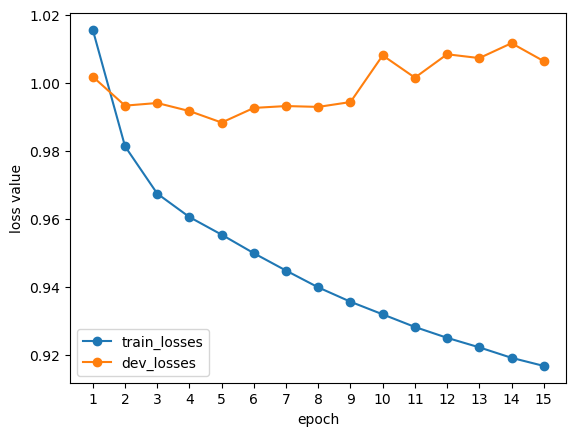

In [50]:
### WRITE YOUR OWN CODE BELOW
vocab_size = len(vectorizer.vocabulary_) + 1
hidden_size = 8 # number of hidden units

# initialize the classifier
ff_classifier_with_embedding_model = FFTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)

# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

epochs = 15

trained_model_2, train_losses_by_epoch_2, dev_losses_by_epoch_2 = train_nn(num_epochs=epochs,
                                                                           model=ff_classifier_with_embedding_model,
                                                                           train_dataloader=train_loader,
                                                                           dev_dataloader=dev_loader)

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

ax = plt.gca()
x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(range(1, epochs+1), train_losses_by_epoch_2, '-o', label='train_losses')
plt.plot(range(1, epochs+1), dev_losses_by_epoch_2, '-o', label='dev_losses')
plt.legend()

 Use two classifiers trained in the cells above to make predictions on the test set and evaluate the results.

In [51]:
from sklearn.metrics import classification_report

# Build a text report showing the main classification metrics
# FFTextClassifier
print(f'A text report for the FFTextClassifier:')
print(classification_report(y_true=gold_labs, y_pred=pred_labs))

# FFTextClassifierWithEmbeddings
gold_labs_2, pred_labs_2 = predict_nn(trained_model_2, test_loader)
print(f'A text report for the FFTextClassifierWithEmbeddings:')
print(classification_report(y_true=gold_labs_2, y_pred=pred_labs_2))

A text report for the FFTextClassifier:
              precision    recall  f1-score   support

           0       0.63      0.24      0.34      3972
           1       0.54      0.75      0.63      5937
           2       0.46      0.51      0.49      2375

    accuracy                           0.54     12284
   macro avg       0.55      0.50      0.49     12284
weighted avg       0.56      0.54      0.51     12284

A text report for the FFTextClassifierWithEmbeddings:
              precision    recall  f1-score   support

           0       0.55      0.11      0.18      3972
           1       0.50      0.66      0.57      5937
           2       0.29      0.44      0.35      2375

    accuracy                           0.44     12284
   macro avg       0.45      0.40      0.36     12284
weighted avg       0.47      0.44      0.40     12284



# 3. Improving the Neural Text Classifier (max. 22 marks)

This section allows you some more free reign to experiment with the neural text classifier. Below, we list several to-dos that you can solve in your own way. Please make sure to label your notebook cells clearly so that it is obvious which to-do each cell corresponds to.

**TO-DO 3a:** Consider the neural text classifiers we have just implemented and the results you obtained in the last to-do. The classifiers have a number of limitations that we could improve. Describe three limitations and how you could improve them. For each improvement you propose, provide a brief explanation (up to 1 paragraph) of how it works. 

Hint: refer to the lectures for some ideas. **(9 marks)**

WRITE YOUR ANSWER HERE:

1. Fine tune the pretrained GloVe Embeddings
> In the block TO-DO 2e, I analysed the reasons for the poor performance of model FFTextClassifierWithEmbeddings, not fine-tuned and overfitted. In this part, I will train a new model to remove these tow limitations. Firstly, I define a new model structure that the pretrained GloVe Embeddings can be fine tune in the train phase. Secondly, I plot a line graph to describe the trainning losses and validation losses for each epoch from 0 to max_epoch, and then select the optimal epoch, in where the validation loss is minimum. Thirdly, I use the optimal epoch to train the final model, which avoids over-fitting. The performance of the final model is then evaluated.

2. Text Classifier based on the Recurrent Neural Networks (RNN)
> The hidden layer of FFTextClassifierWithEmbeddings is a fully connected layer. In this feedforward network, different weights are applied to each input position and all data must be passed in at once, which makes learning harder and scalability trickier. In order to remove this limitaions, we can use a bidirectional Recurrent Neurak Network (Bi-RNN) layer to be the hidden layer instead of fully connectted layer. In this model, the tokens in the text sequence are fed into the RNN one by one. And the last hidden state is taken as a representation of the whole sequence.

3. Text Classifier based on the LSTM
> In this part, I use a Bi-LSTM layer as the hidden layer of the text classifier. The LSTM redesigns the standard RNN. It introduces a memory cell to store context in addition to the hidden layer, which removes the limitation of RNN that cannot recognise long-distance information due to vanishing gradients.

---

**TO-DO 3b:** Implement your improvements and compute the performance of your method. Make sure to comment your code to show where each new step is implemented. Use the validation set for any tuning you decide to do. Present your results clearly. **(13 marks)**



## 3b-1  Fine tune the pretrained GloVe Embeddings

Define a new model structure that the pretrained GloVe Embeddings can be fine tune in the train phase.

In [52]:
# Define the model structure for FFTextClassifierWithFineTuneEmbeddings,
# which is similar with the FFTextClassifierWithEmbeddings, but its parameter "freeze"
# of the embedding_layer is setted as "False". So the pretrained GloVe Embeddings can
# be fine tune in the trainning phase.

class FFTextClassifierWithFineTuneEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # embedding layer with the unfrozen parameters

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer activation
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected layer

Set epochs as 15 to train the model defined in the cell above. And then plot a line graph to describe the trainning losses and the validation losses for each epoch.

Epoch: 1/15 Training Loss: 0.9988 Training Accuracy: 46.8508%
Epoch: 1/15 Validation Loss: 0.9658 Validation Accuracy: 49.8500%
Epoch: 2/15 Training Loss: 0.8996 Training Accuracy: 55.8676%
Epoch: 2/15 Validation Loss: 0.9050 Validation Accuracy: 55.3000%
Epoch: 3/15 Training Loss: 0.8165 Training Accuracy: 61.7319%
Epoch: 3/15 Validation Loss: 0.8633 Validation Accuracy: 58.7500%
Epoch: 4/15 Training Loss: 0.7521 Training Accuracy: 65.4894%
Epoch: 4/15 Validation Loss: 0.8429 Validation Accuracy: 60.8500%
Epoch: 5/15 Training Loss: 0.6979 Training Accuracy: 68.7164%
Epoch: 5/15 Validation Loss: 0.8297 Validation Accuracy: 62.1500%
Epoch: 6/15 Training Loss: 0.6491 Training Accuracy: 71.4984%
Epoch: 6/15 Validation Loss: 0.8368 Validation Accuracy: 63.1000%
Epoch: 7/15 Training Loss: 0.6034 Training Accuracy: 73.9713%
Epoch: 7/15 Validation Loss: 0.8472 Validation Accuracy: 62.2500%
Epoch: 8/15 Training Loss: 0.5609 Training Accuracy: 76.1438%
Epoch: 8/15 Validation Loss: 0.8600 Valida

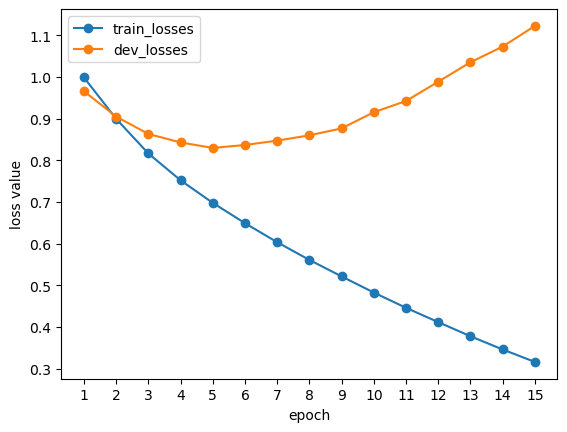

In [53]:
# Obtain the embedding matrix from the pretrained GloVe embeddings,
# which will be used to initialize the embedding_layer of the classifier model
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])

# number of hidden units
hidden_size = 8 
# initialize the classifier
ff_classifier_with_fine_tune_embedding_model = FFTextClassifierWithFineTuneEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

# train model
epochs = 15
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                                     model=ff_classifier_with_fine_tune_embedding_model,
                                                                     train_dataloader=train_loader,
                                                                     dev_dataloader=dev_loader)

# plot a line graph to describe the trainning losses and validation losses
ax = plt.gca()
x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(range(1, epochs+1), train_losses_by_epoch, '-o', label='train_losses')
plt.plot(range(1, epochs+1), dev_losses_by_epoch, '-o', label='dev_losses')
plt.legend()

Based on the line graph plotted in the cell above, I observe that optimal epoch is 5, in where the validation losses is minimum. In the next cell, I train a new model with the optimal epoch and then use this model to make prediction on the test set. Finally, to build a text report showing the main classification metrics.

In [63]:
# Obtain the embedding matrix from the pretrained GloVe embeddings,
# which will be used to initialize the embedding_layer of the classifier model
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])

# number of hidden units
hidden_size = 8 
# initialize the classifier
ff_classifier_with_fine_tune_embedding_model = FFTextClassifierWithFineTuneEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

# train model
epochs = 5  # optimal epoch
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                                     model=ff_classifier_with_fine_tune_embedding_model,
                                                                     train_dataloader=train_loader,
                                                                     dev_dataloader=dev_loader)
# make predictions
gold_labs, pred_labs = predict_nn(trained_model, test_loader)
# print a text report showing the main classification metrics
print(f'A text report for the FFTextClassifierWithEmbeddings:')
print(classification_report(y_true=gold_labs, y_pred=pred_labs))

Epoch: 1/5 Training Loss: 0.9967 Training Accuracy: 48.5476%
Epoch: 1/5 Validation Loss: 0.9636 Validation Accuracy: 51.9500%
Epoch: 2/5 Training Loss: 0.8963 Training Accuracy: 56.6831%
Epoch: 2/5 Validation Loss: 0.9044 Validation Accuracy: 54.8500%
Epoch: 3/5 Training Loss: 0.8110 Training Accuracy: 62.2010%
Epoch: 3/5 Validation Loss: 0.8637 Validation Accuracy: 59.3000%
Epoch: 4/5 Training Loss: 0.7475 Training Accuracy: 65.9169%
Epoch: 4/5 Validation Loss: 0.8432 Validation Accuracy: 59.8000%
Epoch: 5/5 Training Loss: 0.6943 Training Accuracy: 68.9400%
Epoch: 5/5 Validation Loss: 0.8295 Validation Accuracy: 61.5500%
A text report for the FFTextClassifierWithEmbeddings:
              precision    recall  f1-score   support

           0       0.61      0.38      0.47      3972
           1       0.58      0.69      0.63      5937
           2       0.50      0.58      0.54      2375

    accuracy                           0.57     12284
   macro avg       0.56      0.55      0.55 

## 3b-2 Text Classifier based on the Recurrent Neural Networks (RNN)

Define the model structure for RNNTextClassifierWithFineTuneEmbeddings, whose hidden layer consists of an bidirectional RNN layer.

In [60]:
from torch import nn

class RNNTextClassifierWithFineTuneEmbeddings(nn.Module):
    
    def __init__(self, hidden_size, num_classes, embedding_matrix, isBidirectional=True):
        super(RNNTextClassifierWithFineTuneEmbeddings, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # embedding layer initialized by pretrained GloVe embeddings
        # the parameters in the embedding layer is unfrozen
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) 
        
        # import a bi-RNN layer as the hidden layer
        self.rnn = nn.RNN(input_size=self.embedding_size, 
                          hidden_size=hidden_size, 
                          num_layers=1,
                          batch_first=True, # the shape of input is (batch, sequence length, H_in)
                          bidirectional=isBidirectional)
        
        # fully connected output layer
        if isBidirectional:
            # because of the bidirectional RNN, the input size of output_layer is twice of hidden_size
            self.output_layer = nn.Linear(hidden_size*2, num_classes)
        else:
            self.output_layer = nn.Linear(hidden_size, num_classes)
  
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)
        
        # not provide the initial value of h_0, default it is zero
        z, _ = self.rnn(input=embedded_words)               # (batch_size, seq_length, hidden_size*2)
        
        # the output of the last token for each sequence are used to represent the whole sequence
        output = self.output_layer(z[:, -1, :])             # (batch_size, num_classes)
        
        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.
        return output

Set epochs as 15 to train the model defined in the cell above. And then plot a line graph to describe the trainning losses and the validation losses for each epoch.

Epoch: 1/15 Training Loss: 1.0427 Training Accuracy: 43.4221%
Epoch: 1/15 Validation Loss: 1.0171 Validation Accuracy: 44.9500%
Epoch: 2/15 Training Loss: 0.9968 Training Accuracy: 48.9247%
Epoch: 2/15 Validation Loss: 0.9917 Validation Accuracy: 50.2500%
Epoch: 3/15 Training Loss: 0.9309 Training Accuracy: 54.5917%
Epoch: 3/15 Validation Loss: 0.9333 Validation Accuracy: 55.3500%
Epoch: 4/15 Training Loss: 0.8582 Training Accuracy: 60.0570%
Epoch: 4/15 Validation Loss: 0.8972 Validation Accuracy: 58.7500%
Epoch: 5/15 Training Loss: 0.7967 Training Accuracy: 63.9724%
Epoch: 5/15 Validation Loss: 0.8659 Validation Accuracy: 60.8000%
Epoch: 6/15 Training Loss: 0.7443 Training Accuracy: 67.1248%
Epoch: 6/15 Validation Loss: 0.8643 Validation Accuracy: 61.5500%
Epoch: 7/15 Training Loss: 0.6965 Training Accuracy: 69.8301%
Epoch: 7/15 Validation Loss: 0.8633 Validation Accuracy: 61.7500%
Epoch: 8/15 Training Loss: 0.6528 Training Accuracy: 72.3731%
Epoch: 8/15 Validation Loss: 0.8753 Valida

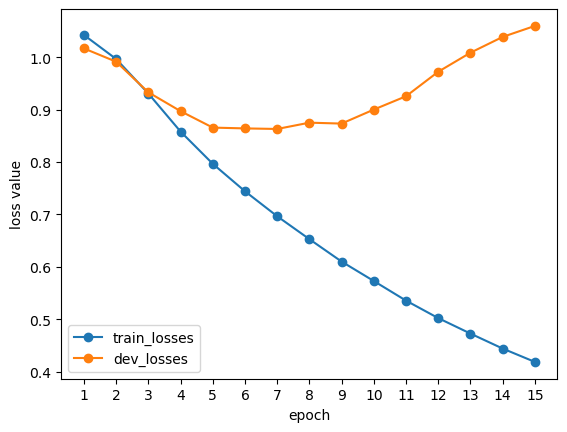

In [61]:
import torch

# Obtain the embedding matrix from the pretrained GloVe embeddings,
# which will be used to initialize the embedding_layer of the classifier model
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])

# number of hidden units
hidden_size = 8 
# initialize the classifier
rnn_classifier_with_fine_tune_embedding_model = RNNTextClassifierWithFineTuneEmbeddings(hidden_size, num_classes, embedding_matrix)
# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

# train model
epochs = 15
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                                     model=rnn_classifier_with_fine_tune_embedding_model,
                                                                     train_dataloader=train_loader,
                                                                     dev_dataloader=dev_loader)

# plot a line graph to describe the trainning losses and validation losses
ax = plt.gca()
x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(range(1, epochs+1), train_losses_by_epoch, '-o', label='train_losses')
plt.plot(range(1, epochs+1), dev_losses_by_epoch, '-o', label='dev_losses')
plt.legend()

Based on the line graph plotted in the cell above, I observe that optimal epoch is 9, in where the validation losses is minimum. In the next cell, I train a new model with the optimal epoch and then use this model to make prediction on the test set. Finally, to build a text report showing the main classification metrics.

In [62]:
# Obtain the embedding matrix from the pretrained GloVe embeddings,
# which will be used to initialize the embedding_layer of the classifier model
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])

# number of hidden units
hidden_size = 8
# initialize the classifier
rnn_classifier_with_fine_tune_embedding_model = RNNTextClassifierWithFineTuneEmbeddings(hidden_size, num_classes, embedding_matrix)
# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

# train model
epochs = 9  # optimal epoch
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                                     model=rnn_classifier_with_fine_tune_embedding_model,
                                                                     train_dataloader=train_loader,
                                                                     dev_dataloader=dev_loader)
# make predictions
gold_labs, pred_labs = predict_nn(trained_model, test_loader)
# print a text report showing the main classification metrics
print(f'A text report for the FFTextClassifierWithEmbeddings:')
print(classification_report(y_true=gold_labs, y_pred=pred_labs))

Epoch: 1/9 Training Loss: 1.0172 Training Accuracy: 45.4719%
Epoch: 1/9 Validation Loss: 1.0133 Validation Accuracy: 45.0000%
Epoch: 2/9 Training Loss: 0.9924 Training Accuracy: 47.9338%
Epoch: 2/9 Validation Loss: 0.9895 Validation Accuracy: 48.6500%
Epoch: 3/9 Training Loss: 0.9380 Training Accuracy: 51.6124%
Epoch: 3/9 Validation Loss: 0.9524 Validation Accuracy: 50.5000%
Epoch: 4/9 Training Loss: 0.8888 Training Accuracy: 54.9446%
Epoch: 4/9 Validation Loss: 0.9386 Validation Accuracy: 53.0000%
Epoch: 5/9 Training Loss: 0.8438 Training Accuracy: 58.5991%
Epoch: 5/9 Validation Loss: 0.9100 Validation Accuracy: 54.8000%
Epoch: 6/9 Training Loss: 0.7965 Training Accuracy: 62.2624%
Epoch: 6/9 Validation Loss: 0.9003 Validation Accuracy: 55.8500%
Epoch: 7/9 Training Loss: 0.7477 Training Accuracy: 65.5420%
Epoch: 7/9 Validation Loss: 0.8872 Validation Accuracy: 58.4000%
Epoch: 8/9 Training Loss: 0.6992 Training Accuracy: 69.0694%
Epoch: 8/9 Validation Loss: 0.8760 Validation Accuracy: 5

## 3b-3 Text Classifier based on the LSTM

Define the model structure for LSTMTextClassifierWithFineTuneEmbeddings, whose hidden layer consists of an bidirectional LSTM layer.

In [64]:
from torch import nn

class LSTMTextClassifierWithFineTuneEmbeddings(nn.Module):
    
    def __init__(self, hidden_size, num_classes, embedding_matrix, isBidirectional=True):
        super(LSTMTextClassifierWithFineTuneEmbeddings, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # embedding layer initialized by pretrained GloVe embeddings
        # the parameters in the embedding layer is unfrozen
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # import a bid-LSTM layer as the hidden layer
        self.lstm = nn.LSTM(input_size=self.embedding_size, 
                                   hidden_size=hidden_size, 
                                   num_layers=1,
                                   batch_first=True,    # the shape of input is (batch, sequence length, H_in)
                                   bidirectional=isBidirectional)
        
        # fully connected output layer
        if isBidirectional:
            # because of the bidirectional LSTM, the input size of output_layer is twice of hidden_size
            self.output_layer = nn.Linear(hidden_size*2, num_classes)
        else:
            self.output_layer = nn.Linear(hidden_size, num_classes)


        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # not provide the initial value of h_0 and c_0, default they are zeros
        z, _ = self.lstm(input=embedded_words)              # (batch_size, seq_length, hidden_size*2)
        
        # the output of the last token for each sequence are used to represent the whole sequence
        output = self.output_layer(z[:, -1, :])              # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.
        return output

Set epochs as 15 to train the model defined in the cell above. And then plot a line graph to describe the trainning losses and the validation losses for each epoch.

Epoch: 1/15 Training Loss: 1.0142 Training Accuracy: 45.2264%
Epoch: 1/15 Validation Loss: 1.0077 Validation Accuracy: 44.5000%
Epoch: 2/15 Training Loss: 0.9452 Training Accuracy: 51.7571%
Epoch: 2/15 Validation Loss: 0.9216 Validation Accuracy: 54.0500%
Epoch: 3/15 Training Loss: 0.8323 Training Accuracy: 60.6336%
Epoch: 3/15 Validation Loss: 0.8407 Validation Accuracy: 61.6000%
Epoch: 4/15 Training Loss: 0.7547 Training Accuracy: 65.3535%
Epoch: 4/15 Validation Loss: 0.8242 Validation Accuracy: 61.5000%
Epoch: 5/15 Training Loss: 0.6982 Training Accuracy: 69.1439%
Epoch: 5/15 Validation Loss: 0.7950 Validation Accuracy: 64.1000%
Epoch: 6/15 Training Loss: 0.6511 Training Accuracy: 72.0202%
Epoch: 6/15 Validation Loss: 0.8029 Validation Accuracy: 65.0500%
Epoch: 7/15 Training Loss: 0.6081 Training Accuracy: 74.4382%
Epoch: 7/15 Validation Loss: 0.8007 Validation Accuracy: 64.7000%
Epoch: 8/15 Training Loss: 0.5695 Training Accuracy: 76.5538%
Epoch: 8/15 Validation Loss: 0.8102 Valida

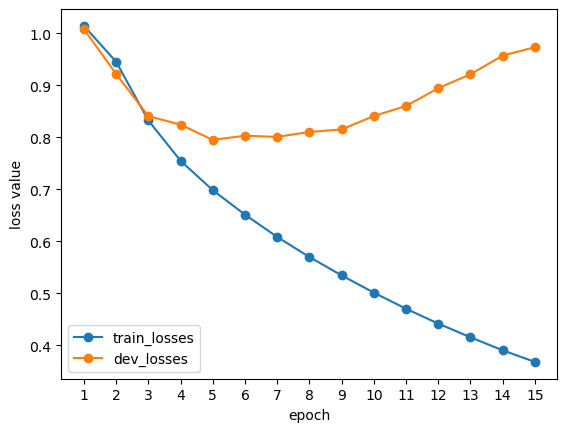

In [65]:
# Obtain the embedding matrix from the pretrained GloVe embeddings,
# which will be used to initialize the embedding_layer of the classifier model
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])

# number of hidden units
hidden_size = 8 
# initialize the classifier
lstm_classifier_with_fine_tune_embedding_model = LSTMTextClassifierWithFineTuneEmbeddings(hidden_size, num_classes, embedding_matrix)
# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

# train model
epochs = 15
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                                     model=lstm_classifier_with_fine_tune_embedding_model,
                                                                     train_dataloader=train_loader,
                                                                     dev_dataloader=dev_loader)

# plot a line graph to describe the trainning losses and validation losses
ax = plt.gca()
x_major_locator = MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(range(1, epochs+1), train_losses_by_epoch, '-o', label='train_losses')
plt.plot(range(1, epochs+1), dev_losses_by_epoch, '-o', label='dev_losses')
plt.legend()

Based on the line graph plotted in the cell above, I observe that optimal epoch is 9, after where the validation losses starts to increase sharply. In the next cell, I train a new model with the optimal epoch and then use this model to make prediction on the test set. Finally, to build a text report showing the main classification metrics.

In [68]:
# Obtain the embedding matrix from the pretrained GloVe embeddings,
# which will be used to initialize the embedding_layer of the classifier model
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])

# number of hidden units
hidden_size = 8
# initialize the classifier
lstm_classifier_with_fine_tune_embedding_model = LSTMTextClassifierWithFineTuneEmbeddings(hidden_size, num_classes, embedding_matrix)
# set the random seed manually to ensure that the experiment are reproducible
seed=33
torch.manual_seed(seed)

# train model
epochs = 9  # optimal epoch
trained_model, train_losses_by_epoch, dev_losses_by_epoch = train_nn(num_epochs=epochs,
                                                                     model=lstm_classifier_with_fine_tune_embedding_model,
                                                                     train_dataloader=train_loader,
                                                                     dev_dataloader=dev_loader)
# make predictions
gold_labs, pred_labs = predict_nn(trained_model, test_loader)
# print a text report showing the main classification metrics
print(f'A text report for the FFTextClassifierWithEmbeddings:')
print(classification_report(y_true=gold_labs, y_pred=pred_labs))

Epoch: 1/9 Training Loss: 1.0142 Training Accuracy: 45.2264%
Epoch: 1/9 Validation Loss: 1.0077 Validation Accuracy: 44.5000%
Epoch: 2/9 Training Loss: 0.9452 Training Accuracy: 51.7571%
Epoch: 2/9 Validation Loss: 0.9216 Validation Accuracy: 54.0500%
Epoch: 3/9 Training Loss: 0.8323 Training Accuracy: 60.6336%
Epoch: 3/9 Validation Loss: 0.8407 Validation Accuracy: 61.6000%
Epoch: 4/9 Training Loss: 0.7547 Training Accuracy: 65.3535%
Epoch: 4/9 Validation Loss: 0.8242 Validation Accuracy: 61.5000%
Epoch: 5/9 Training Loss: 0.6982 Training Accuracy: 69.1439%
Epoch: 5/9 Validation Loss: 0.7950 Validation Accuracy: 64.1000%
Epoch: 6/9 Training Loss: 0.6511 Training Accuracy: 72.0202%
Epoch: 6/9 Validation Loss: 0.8029 Validation Accuracy: 65.0500%
Epoch: 7/9 Training Loss: 0.6081 Training Accuracy: 74.4382%
Epoch: 7/9 Validation Loss: 0.8007 Validation Accuracy: 64.7000%
Epoch: 8/9 Training Loss: 0.5695 Training Accuracy: 76.5538%
Epoch: 8/9 Validation Loss: 0.8102 Validation Accuracy: 6

## Conclusion

I implement the three improved and make predictions on the test set. Tabel 1 below shows these three model's performance plus the baseline model.
Model     | epoch | weight avg F1 score
-------- | ----- | ----
FFTextClassifierWithEmbeddings (baseline)  | 15 | 0.40
FFTextClassifierWithFineTuneEmbeddings  | 5 | 0.56
RNNTextClassifierWithFineTuneEmbeddings | 9 | 0.54
LSTMTextClassifierWithFineTuneEmbeddings | 9 | 0.58